In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel
import scipy.optimize as opt

In [3]:
path = Path('/home/jupyter/data/protiens/')

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [5]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [6]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [7]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [8]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'testt')}))

In [9]:
test_fnames = [path/'testt'/test_id for test_id in test_ids]

In [10]:
test_fnames[:5]

[PosixPath('/home/jupyter/data/protiens/testt/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/jupyter/data/protiens/testt/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/jupyter/data/protiens/testt/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/jupyter/data/protiens/testt/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/jupyter/data/protiens/testt/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [11]:
src.add_test(test_fnames, label='0');

In [12]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [13]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [14]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [15]:
data = (src.transform((trn_tfms, _), size=256)
        .databunch(bs=32).normalize(protein_stats))

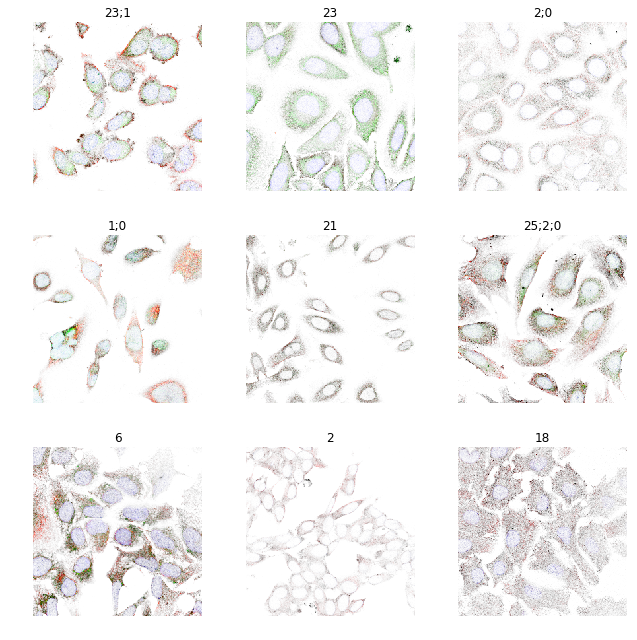

In [17]:
data.show_batch(rows=3, figsize=(9,9))

In [16]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [17]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
th=np.array([0.562155, 0.353543 ,0.491931, 0.289497, 0.271564, 0.376645 ,0.309622 ,0.362597, 0.16261 , 0.140755, 0.128122, 0.34728,  0.247255
, 0.338536, 0.363286 ,0.119595, 0.337536 ,0.360252, 0.379288 ,0.354202, 0.247656 ,0.42753,  0.358528, 0.400727, 0.389776 ,0.527292
, 0.2877,   0.10764 ])
th = torch.from_numpy(th).to(device)
f1_scoreth = partial(fbeta, thresh=th, beta=1)
f1_score5 = partial(fbeta, thresh=0.5, beta=1)

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [22]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=FocalLoss(),
    path=path,    
    metrics=[f_macro,f1_score2,f1_score5], 
)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


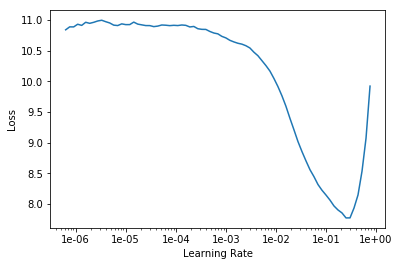

In [29]:
learn.recorder.plot()

In [30]:
lr = 3e-2

In [31]:
learn.fit_one_cycle(2, slice(lr))

Total time: 10:56
epoch  train_loss  valid_loss  f_macro  fbeta  fbeta       
1      1.289770    1.209095    0.366970  0.311876  0.366970  (05:46)
2      0.932255    1.111570    0.532624  0.341340  0.532624  (05:09)



In [32]:
learn.save('stage-1-fl')

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


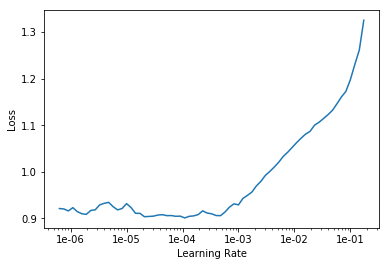

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(10, slice(1e-4, lr/5))

Total time: 1:07:04
epoch  train_loss  valid_loss  f_macro  fbeta  fbeta       
1      0.924568    2.263608    0.493396  0.329957  0.493396  (06:42)
2      0.942452    2.089916    0.509686  0.339080  0.509686  (06:41)
3      0.911605    1.902289    0.540401  0.351236  0.540401  (06:41)
4      0.893115    1.856084    0.552567  0.366475  0.552567  (06:42)
5      0.827114    0.948793    0.582589  0.407127  0.582589  (06:43)
6      0.807134    7.347460    0.574045  0.427335  0.574045  (06:43)
7      0.736421    1.737248    0.616745  0.464417  0.616745  (06:42)
8      0.702297    1.885628    0.658612  0.434177  0.658612  (06:43)
9      0.705396    0.948380    0.651661  0.448333  0.651661  (06:42)
10     0.693536    1.175284    0.654122  0.464263  0.654122  (06:41)



In [23]:
learn.load('stage-2-fl');

GO BIG

In [21]:
data = (src.transform((trn_tfms, _), size=512)
        .databunch(bs=8).normalize(protein_stats))

In [41]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=FocalLoss(),
    path=path,    
    metrics=[f1_score5], 
)

In [21]:
learn.load('stage-2-fl');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


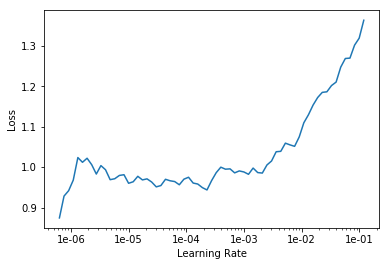

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(10,slice(1e-4,1e-3),wd=0.3)

Total time: 4:33:39
epoch  train_loss  valid_loss  fbeta  fbeta      
1      0.763775    3.053828    0.426077  0.605228  (27:27)
2      0.801829    0.948446    0.401421  0.546158  (27:21)
3      0.838000    0.834215    0.393914  0.558899  (27:22)
4      0.900404    1.026794    0.433181  0.596845  (27:24)
5      0.832132    0.757006    0.435349  0.568865  (27:22)
6      0.773800    0.721719    0.423042  0.581089  (27:22)
7      0.739313    0.715021    0.447708  0.617309  (27:23)
8      0.716926    0.652142    0.446739  0.648259  (27:23)
9      0.711852    0.625526    0.481123  0.666288  (27:09)
10     0.712609    0.623509    0.504152  0.659132  (27:24)



In [39]:
learn.load('fl-stage-1');

In [40]:
learn.fit_one_cycle(5,slice(1e-4,1e-3))

Total time: 1:41:51
epoch  train_loss  valid_loss  fbeta  fbeta      
1      0.739602    0.638394    0.488481  0.669678  (20:21)
2      0.701884    0.690082    0.498615  0.646970  (20:20)
3      0.679122    0.673359    0.484387  0.663329  (20:24)
4      0.712039    0.707103    0.495384  0.672776  (20:22)
5      0.683440    0.665306    0.518473  0.661297  (20:22)



In [41]:
learn.save('FL-stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


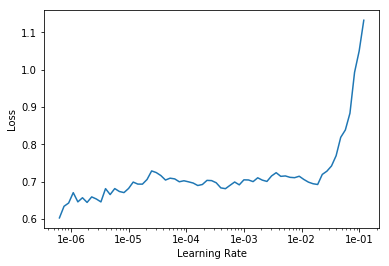

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5,slice(2e-6,4e-4))

Total time: 1:41:48
epoch  train_loss  valid_loss  fbeta  fbeta      
1      0.673872    0.651987    0.524094  0.670243  (20:21)
2      0.651209    0.638418    0.514844  0.659302  (20:23)
3      0.682461    0.649758    0.548403  0.658280  (20:21)
4      0.653233    0.655420    0.507915  0.675792  (20:21)
5      0.666395    0.619350    0.504419  0.685713  (20:20)



In [45]:
learn.save('FL-stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


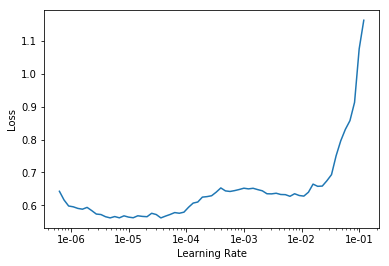

In [24]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5,slice(1e-4,1e-3))

Total time: 1:41:50
epoch  train_loss  valid_loss  fbeta  fbeta      
1      0.686794    0.624603    0.523654  0.682389  (20:21)
2      0.703566    1.032266    0.503232  0.653857  (20:23)
3      0.671427    1.506782    0.487719  0.679407  (20:22)
4      0.703598    0.650777    0.512415  0.683222  (20:21)
5      0.626137    0.661936    0.505518  0.688189  (20:21)



In [42]:
learn.load('FL-stage-4');

In [ ]:
learn.fit_one_cycle(5,slice(2e-6,2e-5))

epoch,train_loss,valid_loss,fbeta
1,0.643503,0.914032,0.668407
2,0.642139,0.828363,0.680366
3,0.635853,0.714189,0.681040
4,0.651082,0.788445,0.667347


In [23]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [24]:
preds_t,y_t = learn.get_preds(DatasetType.Test)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [26]:
pred_sig=preds_t.T
preds_t.shape

(28, 11702)

In [35]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [36]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [47]:
th_t = fit_test(preds_t.T,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(preds_t.T > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(preds_t.T > 0.5).mean(axis=0))

Thresholds:  [0.562155 0.353543 0.491931 0.289497 0.271564 0.376645 0.309622 0.362597 0.16261  0.140755 0.128122 0.34728  0.247255
 0.338536 0.363286 0.119595 0.337536 0.360252 0.379288 0.354202 0.247656 0.42753  0.358528 0.400727 0.389776 0.527292
 0.2877   0.10764 ]
Fractions:  [0.363528 0.043668 0.074517 0.054692 0.068108 0.071697 0.039139 0.073577 0.005469 0.004187 0.002735 0.042899 0.039651
 0.013075 0.043411 0.000684 0.024697 0.012733 0.026748 0.057939 0.00846  0.122287 0.027944 0.073919 0.009656 0.217313
 0.025722 0.001196]
Fractions (th = 0.5):  [4.405230e-01 3.196035e-02 7.203897e-02 2.572210e-02 2.597847e-02 3.896770e-02 9.656469e-03 3.785678e-02 0.000000e+00
 8.545548e-05 2.563664e-04 2.076568e-02 8.203726e-03 3.161853e-03 2.931123e-02 0.000000e+00 4.870962e-03 1.794565e-03
 4.870962e-03 1.991113e-02 0.000000e+00 5.870791e-02 8.631003e-03 4.785507e-02 6.836438e-03 2.817467e-01 3.076397e-03
 5.127329e-04]


In [49]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>th_t)[0]])) for row in np.array(pred_sig)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_512s4.csv', header=True, index=False)

In [60]:
argm=pred_sig.argmax(axis=1)
argm.shape
# pred_sig.shape

(11702,)

In [72]:
# np.nonzero(np.array(preds[0])>0)
# len(pred_labels)
pred2=pd.read_csv(path/'protein_predictions_512s3.csv')
pred2.head(10)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,3 5 6
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,4 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,NaN


In [69]:
j=0
ind=0
for i in pred2['Predicted']:
    if type(i)==float:
#         print(argm[ind])
        pred2['Predicted'][ind]=str(int(argm[ind]))
        j+=1
    ind+=1
print(j,ind)

566 11702


In [71]:
pred2.head(10)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,3 5 6
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,4 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,25


In [73]:
pred2.to_csv(path/'protein_predictions_512s3arg.csv', header=True, index=False)

'4 25'